# "Temporal Difference 2: Estimation of the Action-value Function in Reinforcement Learning"

> Find action values under a given policy
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/TDPrediction_Sarsa_WindyGridworld.png
- categories: [Reinforcement_Learning,TD,  OpenAI,Gym,]
- show_tags: true

In [1]:
# hide
# inspired by 
# https://www.coursera.org/learn/sample-based-learning-methods/lecture/BcMkZ/sarsa-gpi-with-td

In [1]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'Sutton&Barto/ch06/dennybritz_reinforcement-learning_TD/'
base_dir = root_dir + 'Sutton&Barto/'

Mounted at /content/gdrive


In [2]:
# hide
%cd "{base_dir}"

/content/gdrive/My Drive/Sutton&Barto


In [3]:
# hide
!pwd

/content/gdrive/My Drive/Sutton&Barto


## 1. Introduction

In a *Markov Decision Process* (Figure 1) the *agent* and *environment* interacts continuously.

![Figure 1  Agent/Environment interaction in a MDP](../images/mc-prediction_agent-environment_fig1.png "Figure 1  Agent/Environment interaction in a MDP")

More details are available in [Reinforcement Learning: An Introduction by Sutton and Barto](http://incompleteideas.net/book/RLbook2020.pdf).

The dynamics of the MDP is given by
$$ 
\begin{aligned}
p(s',r|s,a) &= Pr\{ S_{t+1}=s',R_{t+1}=r | S_t=s,A_t=a \} \\
\end{aligned}
$$

The *policy* of an agent is a mapping from the current state of the environment to an *action* that the agent needs to take in this state. Formally, a policy is given by
$$ 
\begin{aligned}
\pi(a|s) &= Pr\{A_t=a|S_t=s\}
\end{aligned}
$$

The discounted *return* is given by
$$ 
\begin{aligned}
G_t &= R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... + R_T \\
    &= \sum_{k=0}^\infty \gamma ^k R_{t+1+k}
\end{aligned}
$$
where $\gamma$ is the discount factor and $R$ is the *reward*.

Most reinforcement learning algorithms involve the estimation of value functions - in our present case, the *action-value function*. The action-value function maps each state-action pair to a measure of "how good it is to be in that state-action" in terms of expected rewards. Formally, the action-value function, under policy $\pi$ is given by
$$ 
\begin{aligned}
q_\pi(s,a) &= \mathbb{E}_\pi[G_t|S_t=s, A_t=a]
\end{aligned}
$$

The Temporal Difference (TD) algorithm discussed in this post will numerically estimate $q_\pi(s,a)$.

## 2. Environment

Figure 2 shows the environment we will use in this series: The *Windy Gridworld*:

![Figure 2  Windy Gridworld Environment](../images/WindyGridworldEnv.png "Figure 2  Windy Gridworld Environment")

Each episode starts in the start state, *S* and the agent tries to get to the goal state, *G* in as few steps as possible. There are four movements or actions that can be applied to the environment by the agent:

* up (0)
* right (1)
* down (2)
* left (3)

There is a crosswind running upward through the middle of the grid. The strength of the crosswind is indicated in the center columns of the grid. The strength is added to the vertical displacement of a movement or action, based on the strength indicated for the departing state. For example, if you are one cell to the tight of the goal, the action *left* will take you to the cell just above the goal.

Tasks are *episodic* and undiscounted. All rewards are -1 until the goal is reached.

States are numbered from 0 to 69 in this 7 by 10 grid, in a row-wise fashion starting in the top-left corner.

The environment is implemented using the OpenAI Gym library.

## 3. Agent

The *agent* is the decision maker. It needs to provide instructions to reach the goal in as few steps as possible while compensating for the effect of the wind. After observing the state of the *environment*, expressed as a number from 0 to 69 that reflects the current position in the grid, the agent can take one of the following actions:

* up (0)
* right (1)
* down (2)
* left (3)

## 4. Temporal Difference (TD) Estimation of the Action-value Function, $q_\pi(s,a)$

We will now proceed to estimate the action-value function for the given policy $\pi$. We can take $\gamma=1$ as the sum will remain finite:

In this case the TD method will make the following update:

$$ \large
Q(S_t,A_t) ← Q(S_t,A_t) + α[R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)]
$$

The *target* in this update is:

$$ \large
R_{t+1} + \gamma Q(S_{t+1},A_{t+1})
$$

Algorithms making use of this kind of update rule are known as *SARSA* algorithms. This acronym derives from the fact that the following five elements are needed for an update:

$$ \large
S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1}
$$

## 5. Implementation

We consider two versions of the MC Prediction algorithm: A forward version, and a backward version.

Figure 2 shows the algorithm:

![Figure 2  TD Prediction (Sarsa), for estimating the action-value function](../images/TDPrediction_Sarsa_WindyGridworld_Algorithm.png "Figure 2  TD Prediction (Sarsa), for estimating the action-value function")

Next, we present the code that implements the algorithm.

In [4]:
import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
import pprint as pp
from matplotlib import pyplot as plt
%matplotlib inline
import itertools
from matplotlib import cm, colors

In [5]:
# hide
# if "../../../" not in sys.path:
#   sys.path.append("../../../")

# if "/content/gdrive/My Drive/Sutton&Barto/dennybritz_lib" not in sys.path:
#   sys.path.append("/content/gdrive/My Drive/Sutton&Barto/dennybritz_lib")

from dennybritz_lib import plotting as myplot
from dennybritz_lib.envs.windy_gridworld import WindyGridworldEnv

In [6]:
env = WindyGridworldEnv()

### 5.1 Policy

The following function captures the policy used by the agent:

In [7]:
def create_policy_random(n_A):
  def policy_function(observation):
    #probabilities for each action, length n_A:
    action_probs = np.ones(n_A, dtype=float)/n_A
    return np.random.choice(np.arange(len(action_probs)), p=action_probs)
  return policy_function      

### 5.3 Main loop

The following function implements the main loop of the algorithm. It iterates for ``n_episodes``. It also takes a list of ``monitored_state_actions`` for which it will record the evolution of action values. This is handy for showing how action values converge during the process.

In [8]:
def td_prediction_sarsa(env, n_episodes, gamma=1.0, alpha=0.5, epsilon=0.1, monitored_state_actions=None, diag=False):
  Q = defaultdict(lambda: np.zeros(env.action_space.n))
  pi = create_policy_random(env.action_space.n)
  monitored_state_action_values = defaultdict(list)
  stats = myplot.EpisodeStats(
    episode_lengths=np.zeros(n_episodes),
    episode_rewards=np.zeros(n_episodes))
  for i in range(n_episodes):
    if (i + 1)%10 == 0: print("\rEpisode {}/{}".format(i + 1, n_episodes), end=""); sys.stdout.flush()
    print(f'\nepisode {i}:') if diag else None
    #---initialize St    
    St = env.reset()
    #---choose At from St, using given policy
    At = pi(St)
    #---repeat for each step of episode
    for t in itertools.count(): #while True:
      #---take action At, observe Rt+1, St+1
      Stp1, Rtp1, done, _ = env.step(At) # St+1, Rt+1 OR s',r
      #---choose At+1 from St+1, using given policy
      Atp1 = pi(Stp1)
      print(f"---t={t} St, At, Rt+1, St+1, At+1: {St, At, Rtp1, Stp1, Atp1}") if diag else None
      stats.episode_rewards[i] += Rtp1; stats.episode_lengths[i] = t
      #---update Q
      Q[St][At] = Q[St][At] + alpha*( Rtp1 + gamma*Q[Stp1][Atp1] - Q[St][At] ); print(f"Q[St][At]: {Q[St][At]}") if diag else None
      St = Stp1; At = Atp1
      if done:
          break
    #---until St is terminal
    if monitored_state_actions:
      for msa in monitored_state_actions: 
        s = msa[0]; a = msa[1]            
        # print("\rQ[{}]: {}".format(msa, Q[s][a]), end=""); sys.stdout.flush()
        monitored_state_action_values[msa].append(Q[s][a])
  return Q, stats, monitored_state_action_values

### 5.4 Monitored state-actions

Let's pick a number of state-actions to monitor. Each tuple captures the state number (0 to 69) and an action (0, 1, 2, 3)

In [9]:
monitored_state_actions = [(0, 1), (7, 3), (57, 2), (68, 0)]

In [10]:
Q,stats,monitored_state_action_values = td_prediction_sarsa(
  env, 
  n_episodes=10, 
  alpha=0.5,
  monitored_state_actions=monitored_state_actions,  
  diag=False)

Episode 10/10

In [11]:
Q

defaultdict(<function __main__.td_prediction_sarsa.<locals>.<lambda>>,
            {0: array([-130.21765987, -143.5432508 , -119.89485328, -133.88642559]),
             1: array([-143.25586199, -144.70357216, -141.7840175 , -137.20258816]),
             2: array([-151.44191022, -170.21283604, -148.33133697, -137.08449294]),
             3: array([-164.76415063, -174.77154891, -154.4987116 , -154.79278312]),
             4: array([-181.62326961, -184.40197609, -183.45675144, -164.50839718]),
             5: array([-188.44514126, -189.42454014, -187.66972352, -181.48821112]),
             6: array([-187.85897908, -188.70534129, -188.48478915, -187.04432567]),
             7: array([-188.82039454, -182.29671548, -188.23317708, -187.92342654]),
             8: array([-182.68005963, -178.9240007 , -179.33804605, -185.96499726]),
             9: array([-168.6376302 , -183.74847608, -133.41859813, -184.85356041]),
             10: array([-128.70861097, -139.0681346 , -129.06622311, -133.00609

In [12]:
Q[50]

array([-107.01682414,  -95.61187957,  -66.11468079,  -80.64601024])

In [13]:
Q[7][0], Q[7][1], Q[7][2], Q[7][3]

(-188.82039454324692,
 -182.2967154789809,
 -188.23317708192786,
 -187.92342653635168)

In [14]:
print(monitored_state_actions[0])
print(monitored_state_action_values[monitored_state_actions[0]])

(0, 1)
[-9.675669392355946, -15.124011334242805, -26.71110515544056, -38.7291227291568, -76.69174707511156, -73.38136859322967, -73.38136859322967, -121.03548085187168, -142.42781434742943, -143.54325080210805]


In [15]:
# last value in monitored_state_actions should be value in Q
msa = monitored_state_actions[0]; print('msa:', msa)
s = msa[0]; print('s:', s)
a = msa[1]; print('a:', a)
monitored_state_action_values[msa][-1], Q[s][a] #monitored_stuff[msa] BUT Q[s][a]

msa: (0, 1)
s: 0
a: 1


(-143.54325080210805, -143.54325080210805)

### 5.5 Run 1

In [16]:
Q1,stats,monitored_state_action_values1 = td_prediction_sarsa(
  env, 
  n_episodes=20, 
  alpha=0.5,
  monitored_state_actions=monitored_state_actions,  
  diag=False)

Episode 20/20

In [17]:
# last value in monitored_state_actions should be value in Q
msa = monitored_state_actions[0]; print('msa:', msa)
s = msa[0]; print('s:', s)
a = msa[1]; print('a:', a)
monitored_state_action_values1[msa][-1], Q1[s][a] #monitored_stuff[msa] BUT Q[s][a]

msa: (0, 1)
s: 0
a: 1


(-349.70479826983944, -349.70479826983944)

#### 5.5.1 Monitored state-actions
The following chart shows how the values of the 4 monitored state-actions converge to their values:

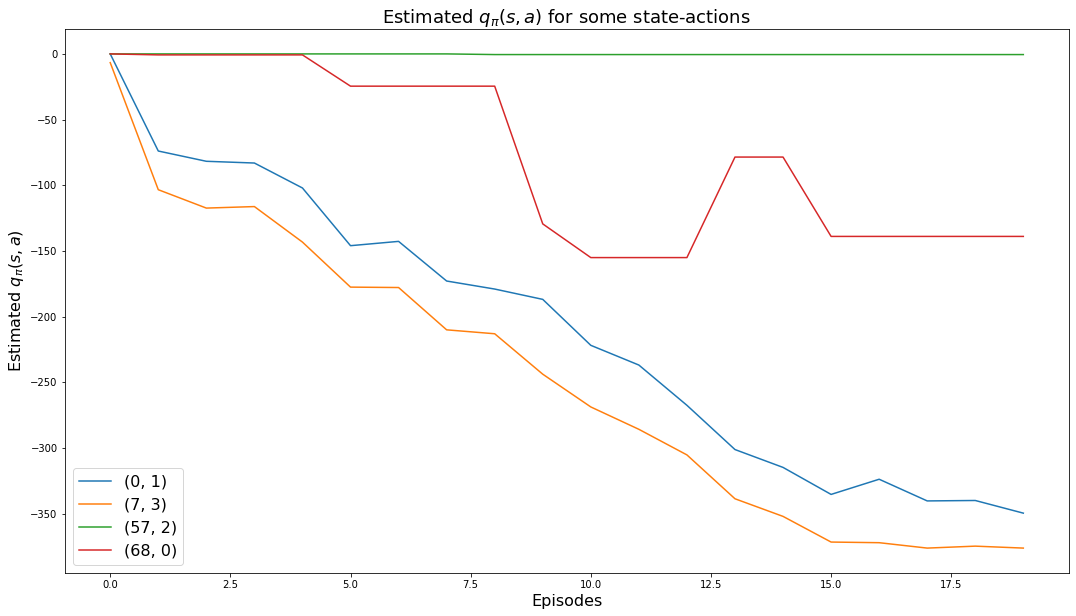

In [18]:
plt.rcParams["figure.figsize"] = (18,10)
for msa in monitored_state_actions:
  plt.plot(monitored_state_action_values1[msa])
plt.title('Estimated $q_\pi(s,a)$ for some state-actions', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $q_\pi(s,a)$', fontsize=16)
plt.legend(monitored_state_actions, fontsize=16)
plt.show()

#### 5.5.2 Other metrics
Here are some additional metrics:

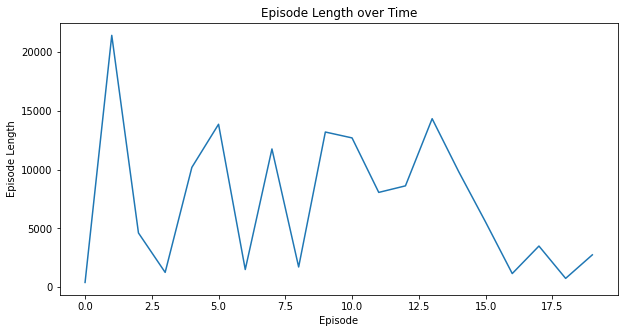

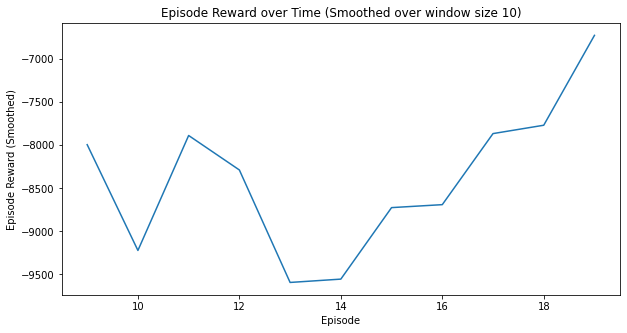

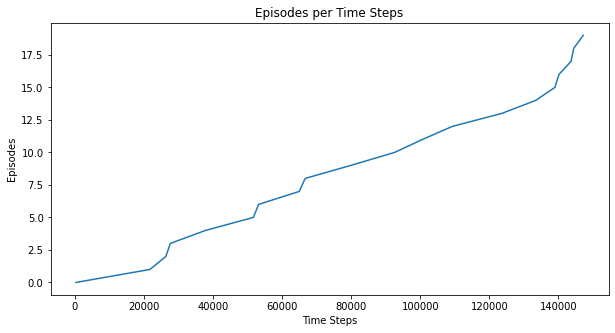

In [19]:
myplot.plot_episode_stats(stats);

#### 5.5.3 State-value function
To make a plot of the state-value function we derive the state-value function from the action-value function:

In [20]:
# create state-value function from action-value function 
V1 = defaultdict(float)
for state, actions in Q1.items():
    action_value = np.max(actions)
    V1[state] = action_value

To make a plot of the state-value function we reshape the values to align with the Windy Gridworld pattern.

In [21]:
# convert V1 to V1p for plotting
states_shape = (7, 10)
nS = np.prod(states_shape)
V1p = {}
for s in range(nS):
  position = np.unravel_index(s, states_shape); #print(f"position: {position}")
  V1p[position] = V1[s]

In [22]:
V1p

{(0, 0): -327.6071922498886,
 (0, 1): -323.86069090792967,
 (0, 2): -328.85814327332844,
 (0, 3): -344.9640026141235,
 (0, 4): -367.7745154409497,
 (0, 5): -371.3770111178868,
 (0, 6): -375.48137244500117,
 (0, 7): -366.93211438939494,
 (0, 8): -361.72724799049274,
 (0, 9): -351.35391456286993,
 (1, 0): -320.53422131352875,
 (1, 1): -325.2242150311729,
 (1, 2): -324.239772198814,
 (1, 3): -350.04577508652443,
 (1, 4): -361.45496680515873,
 (1, 5): -286.1746103140105,
 (1, 6): -109.44140511014332,
 (1, 7): -360.94038190900784,
 (1, 8): -348.67781390674645,
 (1, 9): -290.36373655105893,
 (2, 0): -302.1787655552366,
 (2, 1): -296.58457760037595,
 (2, 2): -316.05581872302525,
 (2, 3): -344.02910502918513,
 (2, 4): -298.41429286385596,
 (2, 5): -153.72312343131915,
 (2, 6): 0.0,
 (2, 7): -295.20593059832555,
 (2, 8): -355.92922004811703,
 (2, 9): -184.34839030676795,
 (3, 0): -290.92803360750634,
 (3, 1): -282.7727544690155,
 (3, 2): -282.5124479431155,
 (3, 3): -332.95139123228034,
 (3, 4)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


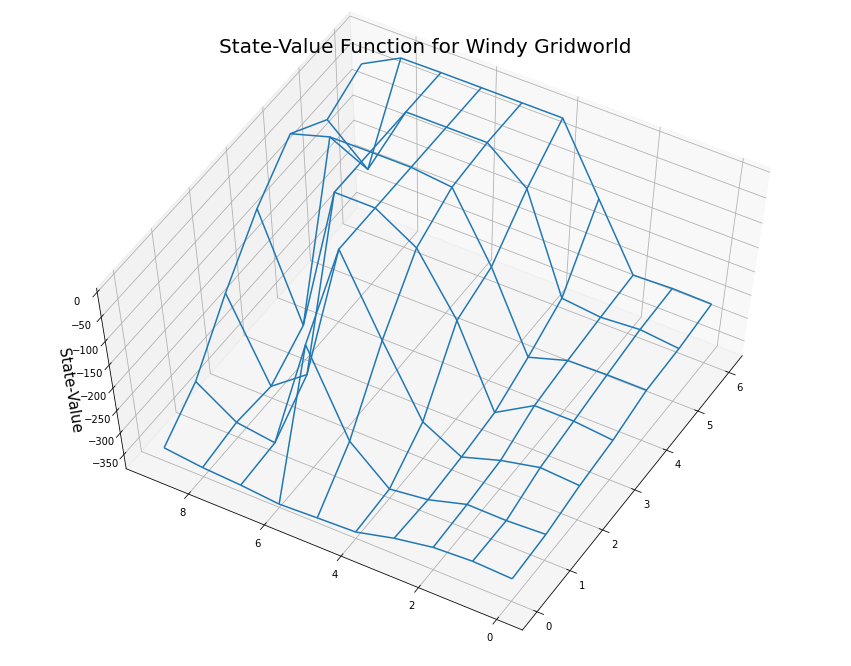

In [23]:
myplot.plot_state_value_surface(V1p, title='State-Value Function for Windy Gridworld', wireframe=True, azim=-150, elev=60);

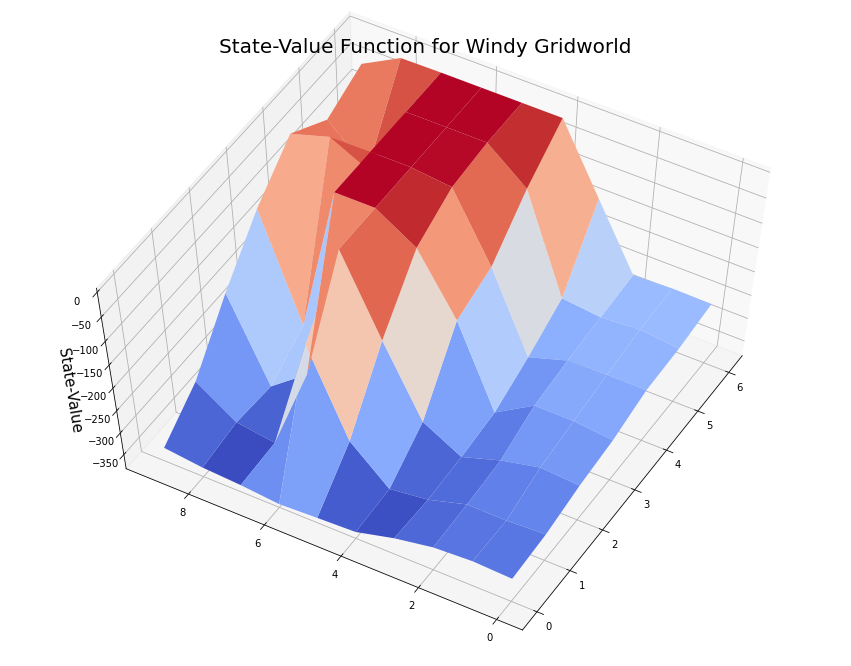

In [24]:
myplot.plot_state_value_surface(V1p, title='State-Value Function for Windy Gridworld', wireframe=False, azim=-150, elev=60);

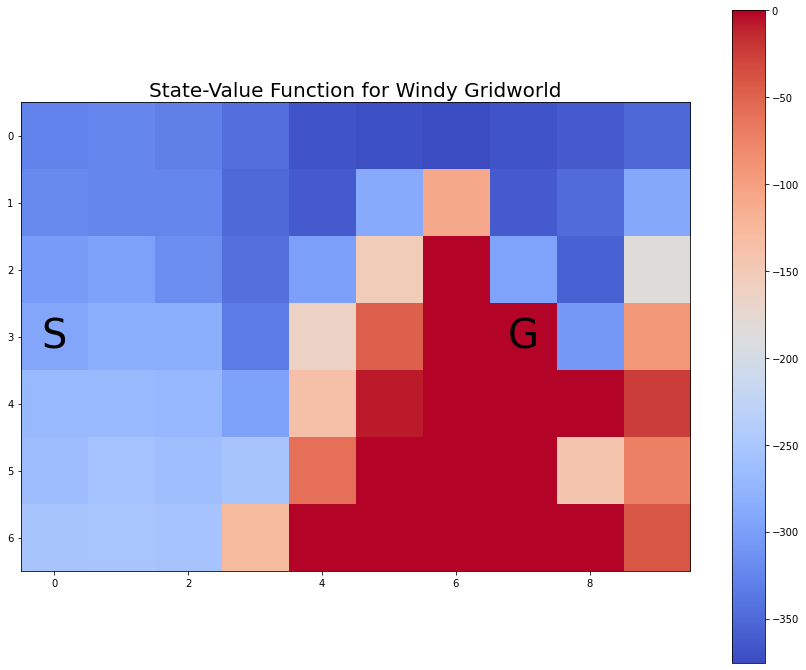

In [25]:
myplot.plot_state_value_heatmap_windy_gridworld(V1p, title='State-Value Function for Windy Gridworld');

#### 5.5.4 Policy function

In [26]:
# create policy function from action-value function 
P1 = defaultdict(float)
for state, actions in Q1.items():
    action = np.argmax(actions)
    P1[state] = action

In [27]:
# convert P1 to P1p for plotting
states_shape = (7, 10)
nS = np.prod(states_shape)
P1p = {}
for s in range(nS):
  position = np.unravel_index(s, states_shape); #print(f"position: {position}")
  P1p[position] = P1[s]

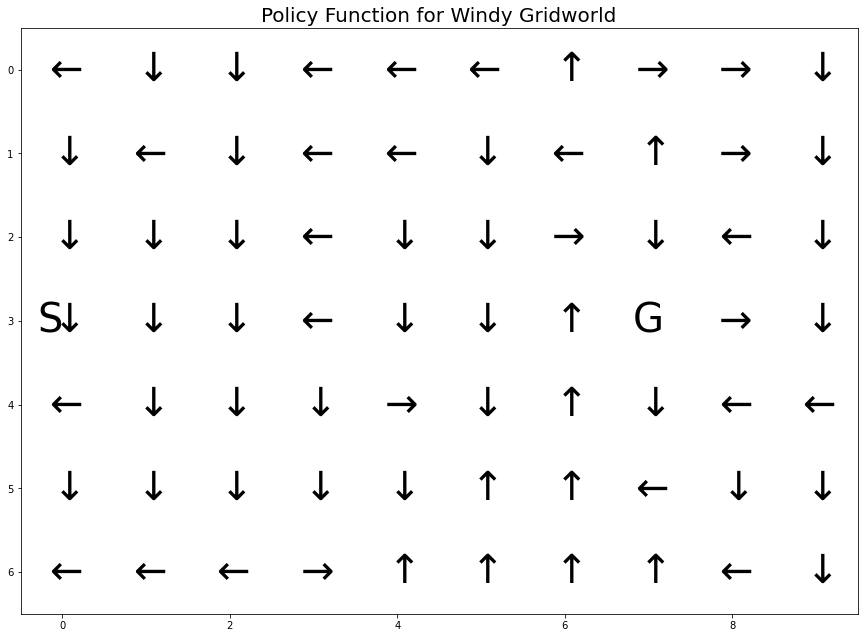

In [29]:
myplot.plot_policy_windy_gridworld(P1p, title='Policy Function for Windy Gridworld');

### 5.6 Run 2

In [30]:
Q2,stats,monitored_state_action_values2 = td_prediction_sarsa(
    env, 
    n_episodes=200, 
    alpha=0.5,    
    monitored_state_actions=monitored_state_actions,
    diag=False)

Episode 200/200

In [31]:
# last value in monitored_state_actions should be value in Q
msa = monitored_state_actions[0]; print('msa:', msa)
s = msa[0]; print('s:', s)
a = msa[1]; print('a:', a)
monitored_state_action_values2[msa][-1], Q2[s][a] #monitored_stuff[msa] BUT Q[s][a]

msa: (0, 1)
s: 0
a: 1


(-1977.1839173706244, -1977.1839173706244)

#### 5.6.1 Monitored state-actions
The following chart shows how the values of the monitored state-actions converge to their values:

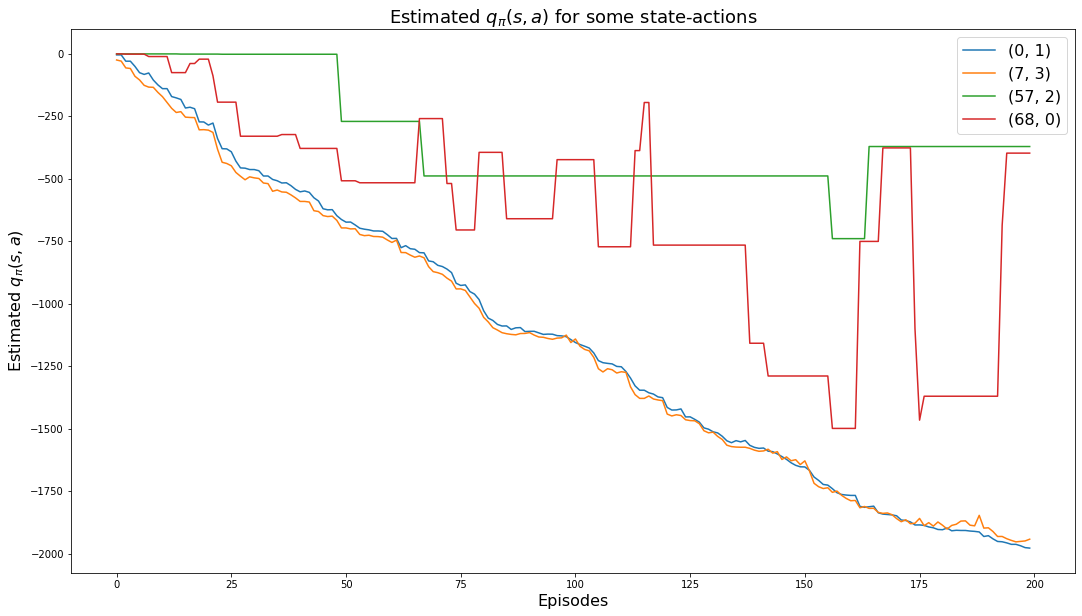

In [32]:
plt.rcParams["figure.figsize"] = (18,10)
for msa in monitored_state_actions:
  plt.plot(monitored_state_action_values2[msa])
plt.title('Estimated $q_\pi(s,a)$ for some state-actions', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $q_\pi(s,a)$', fontsize=16)
plt.legend(monitored_state_actions, fontsize=16)
plt.show()

#### 5.6.2 Other metrics
Here are some additional metrics:

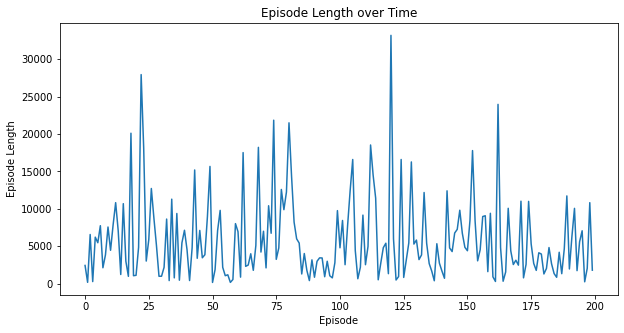

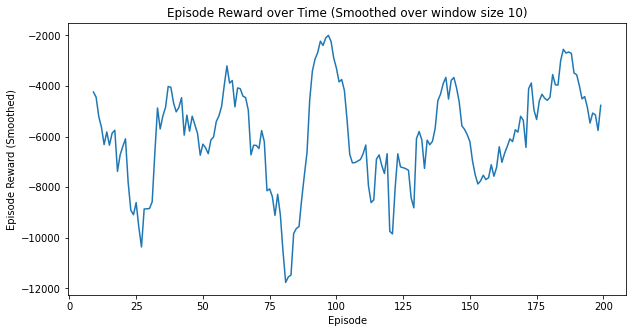

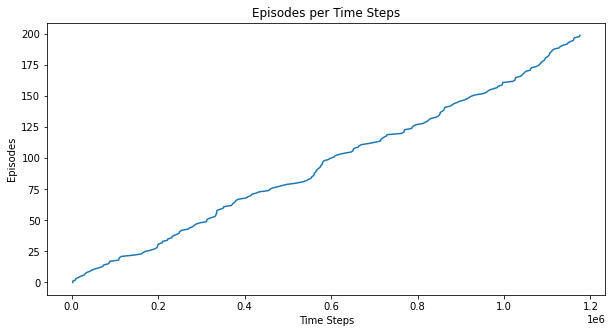

In [33]:
myplot.plot_episode_stats(stats);

#### 5.6.3 State-value function
To make a plot of the state-value function we reshape the values to align with the Windy Gridworld pattern.

In [34]:
# create state-value function from action-value function 
V2 = defaultdict(float)
for state, actions in Q2.items():
    action_value = np.max(actions)
    V2[state] = action_value

In [35]:
# convert V2 to V2p for plotting
states_shape = (7, 10)
nS = np.prod(states_shape)
V2p = {}
for s in range(nS):
  position = np.unravel_index(s, states_shape); #print(f"position: {position}")
  V2p[position] = V2[s]

In [36]:
V2p

{(0, 0): -1976.6067124687627,
 (0, 1): -1977.0994015067404,
 (0, 2): -1972.8905470947368,
 (0, 3): -1975.9459020505924,
 (0, 4): -1956.4970137697956,
 (0, 5): -1961.3755964291297,
 (0, 6): -1939.7875789658233,
 (0, 7): -1907.4095018879138,
 (0, 8): -1866.1975642206223,
 (0, 9): -1861.7647547127203,
 (1, 0): -1971.2271431010415,
 (1, 1): -1970.6705744665903,
 (1, 2): -1968.5256728794718,
 (1, 3): -1977.9058270219132,
 (1, 4): -1967.3140943562007,
 (1, 5): -1920.1807571550594,
 (1, 6): -1703.3399089623265,
 (1, 7): -1901.4968212332117,
 (1, 8): -1905.9896006723643,
 (1, 9): -1873.6567681088377,
 (2, 0): -1960.6615239439993,
 (2, 1): -1953.1921260894733,
 (2, 2): -1967.237191187847,
 (2, 3): -1972.6071747637784,
 (2, 4): -1945.9910533887498,
 (2, 5): -1822.6856722595462,
 (2, 6): -1250.4065633273499,
 (2, 7): -1891.0524309422026,
 (2, 8): -1884.284928372635,
 (2, 9): -1850.3809755131779,
 (3, 0): -1949.4001251122963,
 (3, 1): -1943.796407642659,
 (3, 2): -1950.1484344415687,
 (3, 3): -196

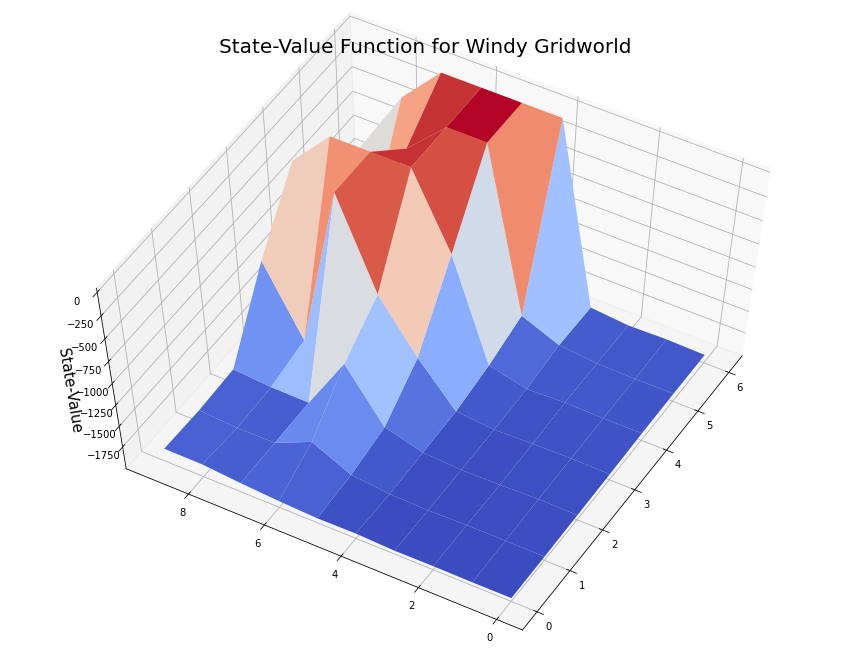

In [37]:
myplot.plot_state_value_surface(V2p, title='State-Value Function for Windy Gridworld', wireframe=False, azim=-150, elev=60);

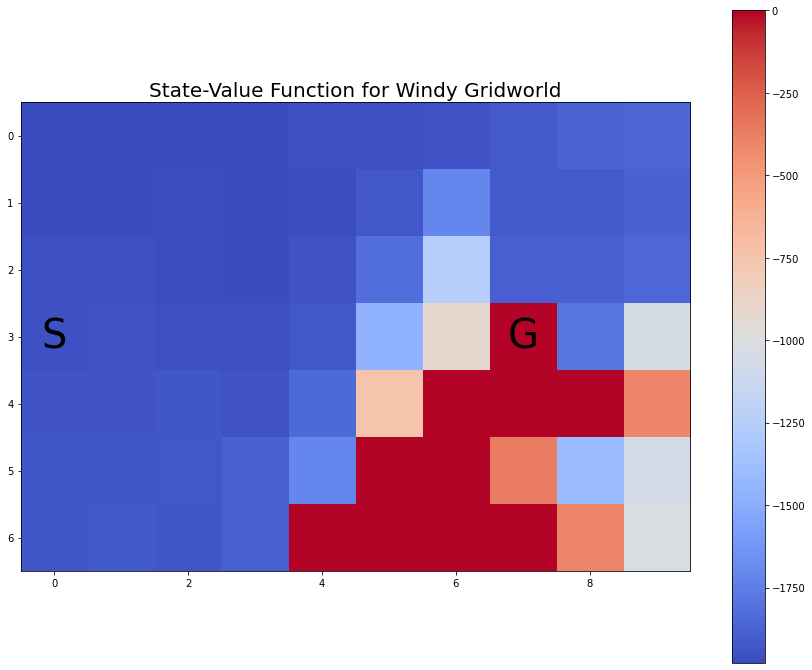

In [38]:
myplot.plot_state_value_heatmap_windy_gridworld(V2p, title='State-Value Function for Windy Gridworld');

#### 5.6.4 Policy function

In [39]:
# create policy function from action-value function 
P2 = defaultdict(float)
for state, actions in Q2.items():
    action = np.argmax(actions)
    P2[state] = action

In [40]:
# convert P2 to P2p for plotting
states_shape = (7, 10)
nS = np.prod(states_shape)
P2p = {}
for s in range(nS):
  position = np.unravel_index(s, states_shape); #print(f"position: {position}")
  P2p[position] = P2[s]

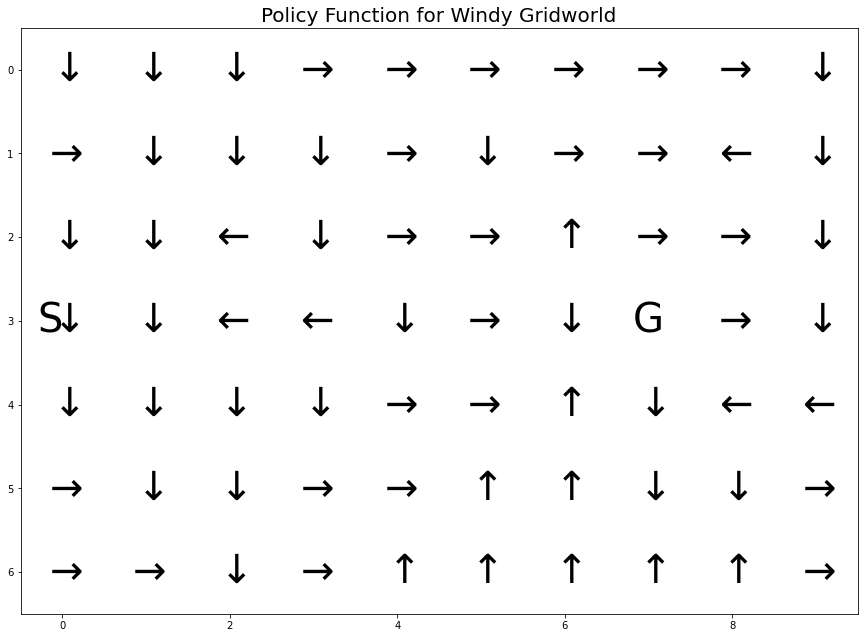

In [42]:
# myplot.plot_state_value_heatmap_windy_gridworld(P2p, title='Policy Function for Windy Gridworld');
myplot.plot_policy_windy_gridworld(P2p, title='Policy Function for Windy Gridworld');